In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_dir = '/content/drive/My Drive/covid19data'

'''train_dir = os.path.join(base_dir, 'train')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'CT_COVID')

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])'''

"train_dir = os.path.join(base_dir, 'train')\n\n# Directory with our training cat pictures\ntrain_cats_dir = os.path.join(train_dir, 'CT_COVID')\n\ntrain_cat_fnames = os.listdir(train_cats_dir)\nprint(train_cat_fnames[:10])"

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training Covid-19 X-ray data
train_Covid_Xray_dir = os.path.join(train_dir, 'CT_COVID')

# Directory with our training normal X-ray data
train_normal_Xray_dir = os.path.join(train_dir, 'CT_NonCOVID')

# Directory with our test Covid-19 X-ray data
validation_Covid_Xray_dir = os.path.join(validation_dir, 'CT_COVID')

# Directory with our test normal X-ray data
validation_normal_Xray_dir = os.path.join(validation_dir, 'CT_NonCOVID')

In [ ]:
train_cat_fnames = os.listdir(train_Covid_Xray_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_normal_Xray_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['PIIS0140673620303603%6.png', '2020.03.10.20032136-p34-118_1%1.png', '2020.03.12.20027185-p8-217.png', '2020.03.04.20031039-p23-97_2%2.png', 'Comparison-of-different-samples-for-2019-novel-cor_2020_International-Journa-p2-21%4.png', 'bmj.m606.full-p4-22%4.png', '2020.03.12.20034686-p17-91-5.png', '2020.03.13.20035212-p23-155.png', '2020.03.18.20038125-p15-54-2.png', '2020.03.12.20034686-p17-91-1.png']
['102.png', '103.png', '104.png', '1049.png', '1050.png', '1058.png', '1059.png', '1060.png', '1061.png', '1062.png']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training Covid_Xray images:', len(os.listdir(train_Covid_Xray_dir)))
print('total training normal_Xray images:', len(os.listdir(train_normal_Xray_dir)))
print('total validation Covid_Xray images:', len(os.listdir(validation_Covid_Xray_dir)))
print('total validation normal_Xray images:', len(os.listdir(validation_normal_Xray_dir)))

total training Covid_Xray images: 331
total training normal_Xray images: 70
total validation Covid_Xray images: 20
total validation normal_Xray images: 22


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem.

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)       

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing


As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 401 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=8,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
10/10 - 5s - loss: 1.5513 - acc: 0.7017 - val_loss: 1.7977 - val_acc: 0.4762
Epoch 2/15
10/10 - 5s - loss: 0.4393 - acc: 0.8350
Epoch 3/15
10/10 - 5s - loss: 0.2853 - acc: 0.8900
Epoch 4/15
10/10 - 5s - loss: 0.3923 - acc: 0.8500
Epoch 5/15
10/10 - 5s - loss: 0.2506 - acc: 0.9100
Epoch 6/15
10/10 - 4s - loss: 0.2294 - acc: 0.9171
Epoch 7/15
10/10 - 4s - loss: 0.3084 - acc: 0.9061
Epoch 8/15
10/10 - 5s - loss: 0.2397 - acc: 0.9000
Epoch 9/15
10/10 - 5s - loss: 0.1657 - acc: 0.9350
Epoch 10/15
10/10 - 5s - loss: 0.2249 - acc: 0.9350
Epoch 11/15
10/10 - 4s - loss: 0.1912 - acc: 0.9392
Epoch 12/15
10/10 - 4s - loss: 0.1865 - acc: 0.9448
Epoch 13/15
10/10 - 5s - loss: 0.0761 - acc: 0.9650
Epoch 14/15
10/10 - 5s - loss: 0.1150 - acc: 0.9550
Epoch 15/15
10/10 - 4s - loss: 0.1843 - acc: 0.9282


### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

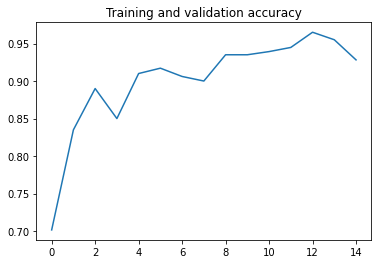

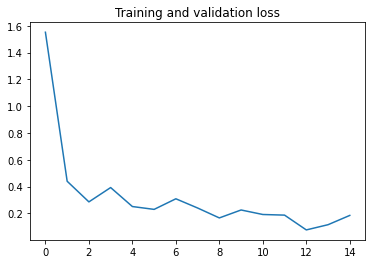

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
#plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
#plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)